In [39]:
import os
import cv2
import pickle
import numpy as np
import pandas as pd
import random
import shutil
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, RandomRotation, RandomFlip, Resizing, Rescaling,Input
from keras.models import Sequential,Model
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.models import save_model
from tensorflow.keras import layers, models

import glob

In [40]:
tf.random.set_seed(10)

In [41]:
import pathlib

In [42]:
from PIL import Image

In [43]:
data_dir = pathlib.Path("C:/Users/palma/Downloads/Nueva carpeta (6)/val/")  

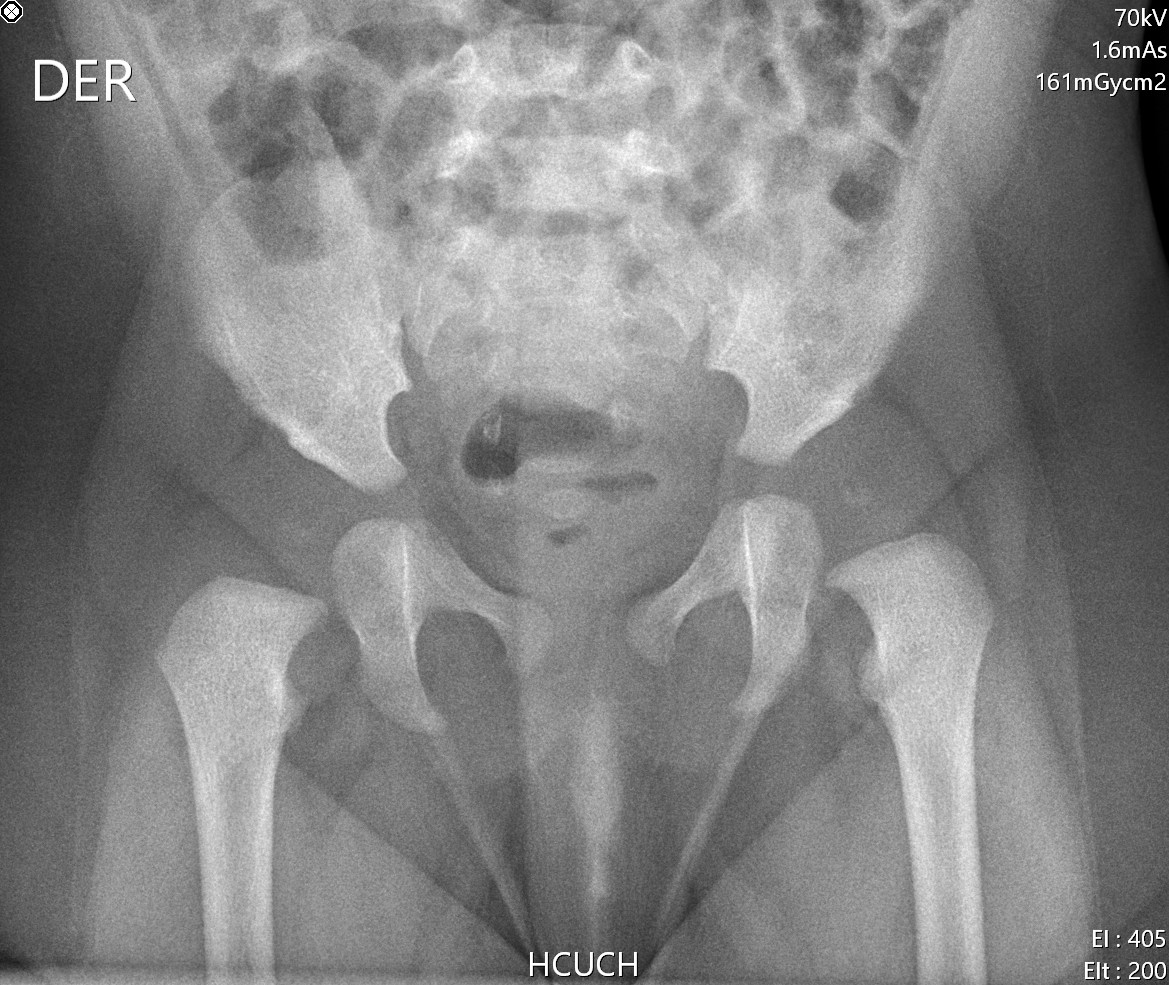

In [44]:
ddh1 = list(data_dir.glob('DDH/*'))
Image.open(str(ddh1[0]))

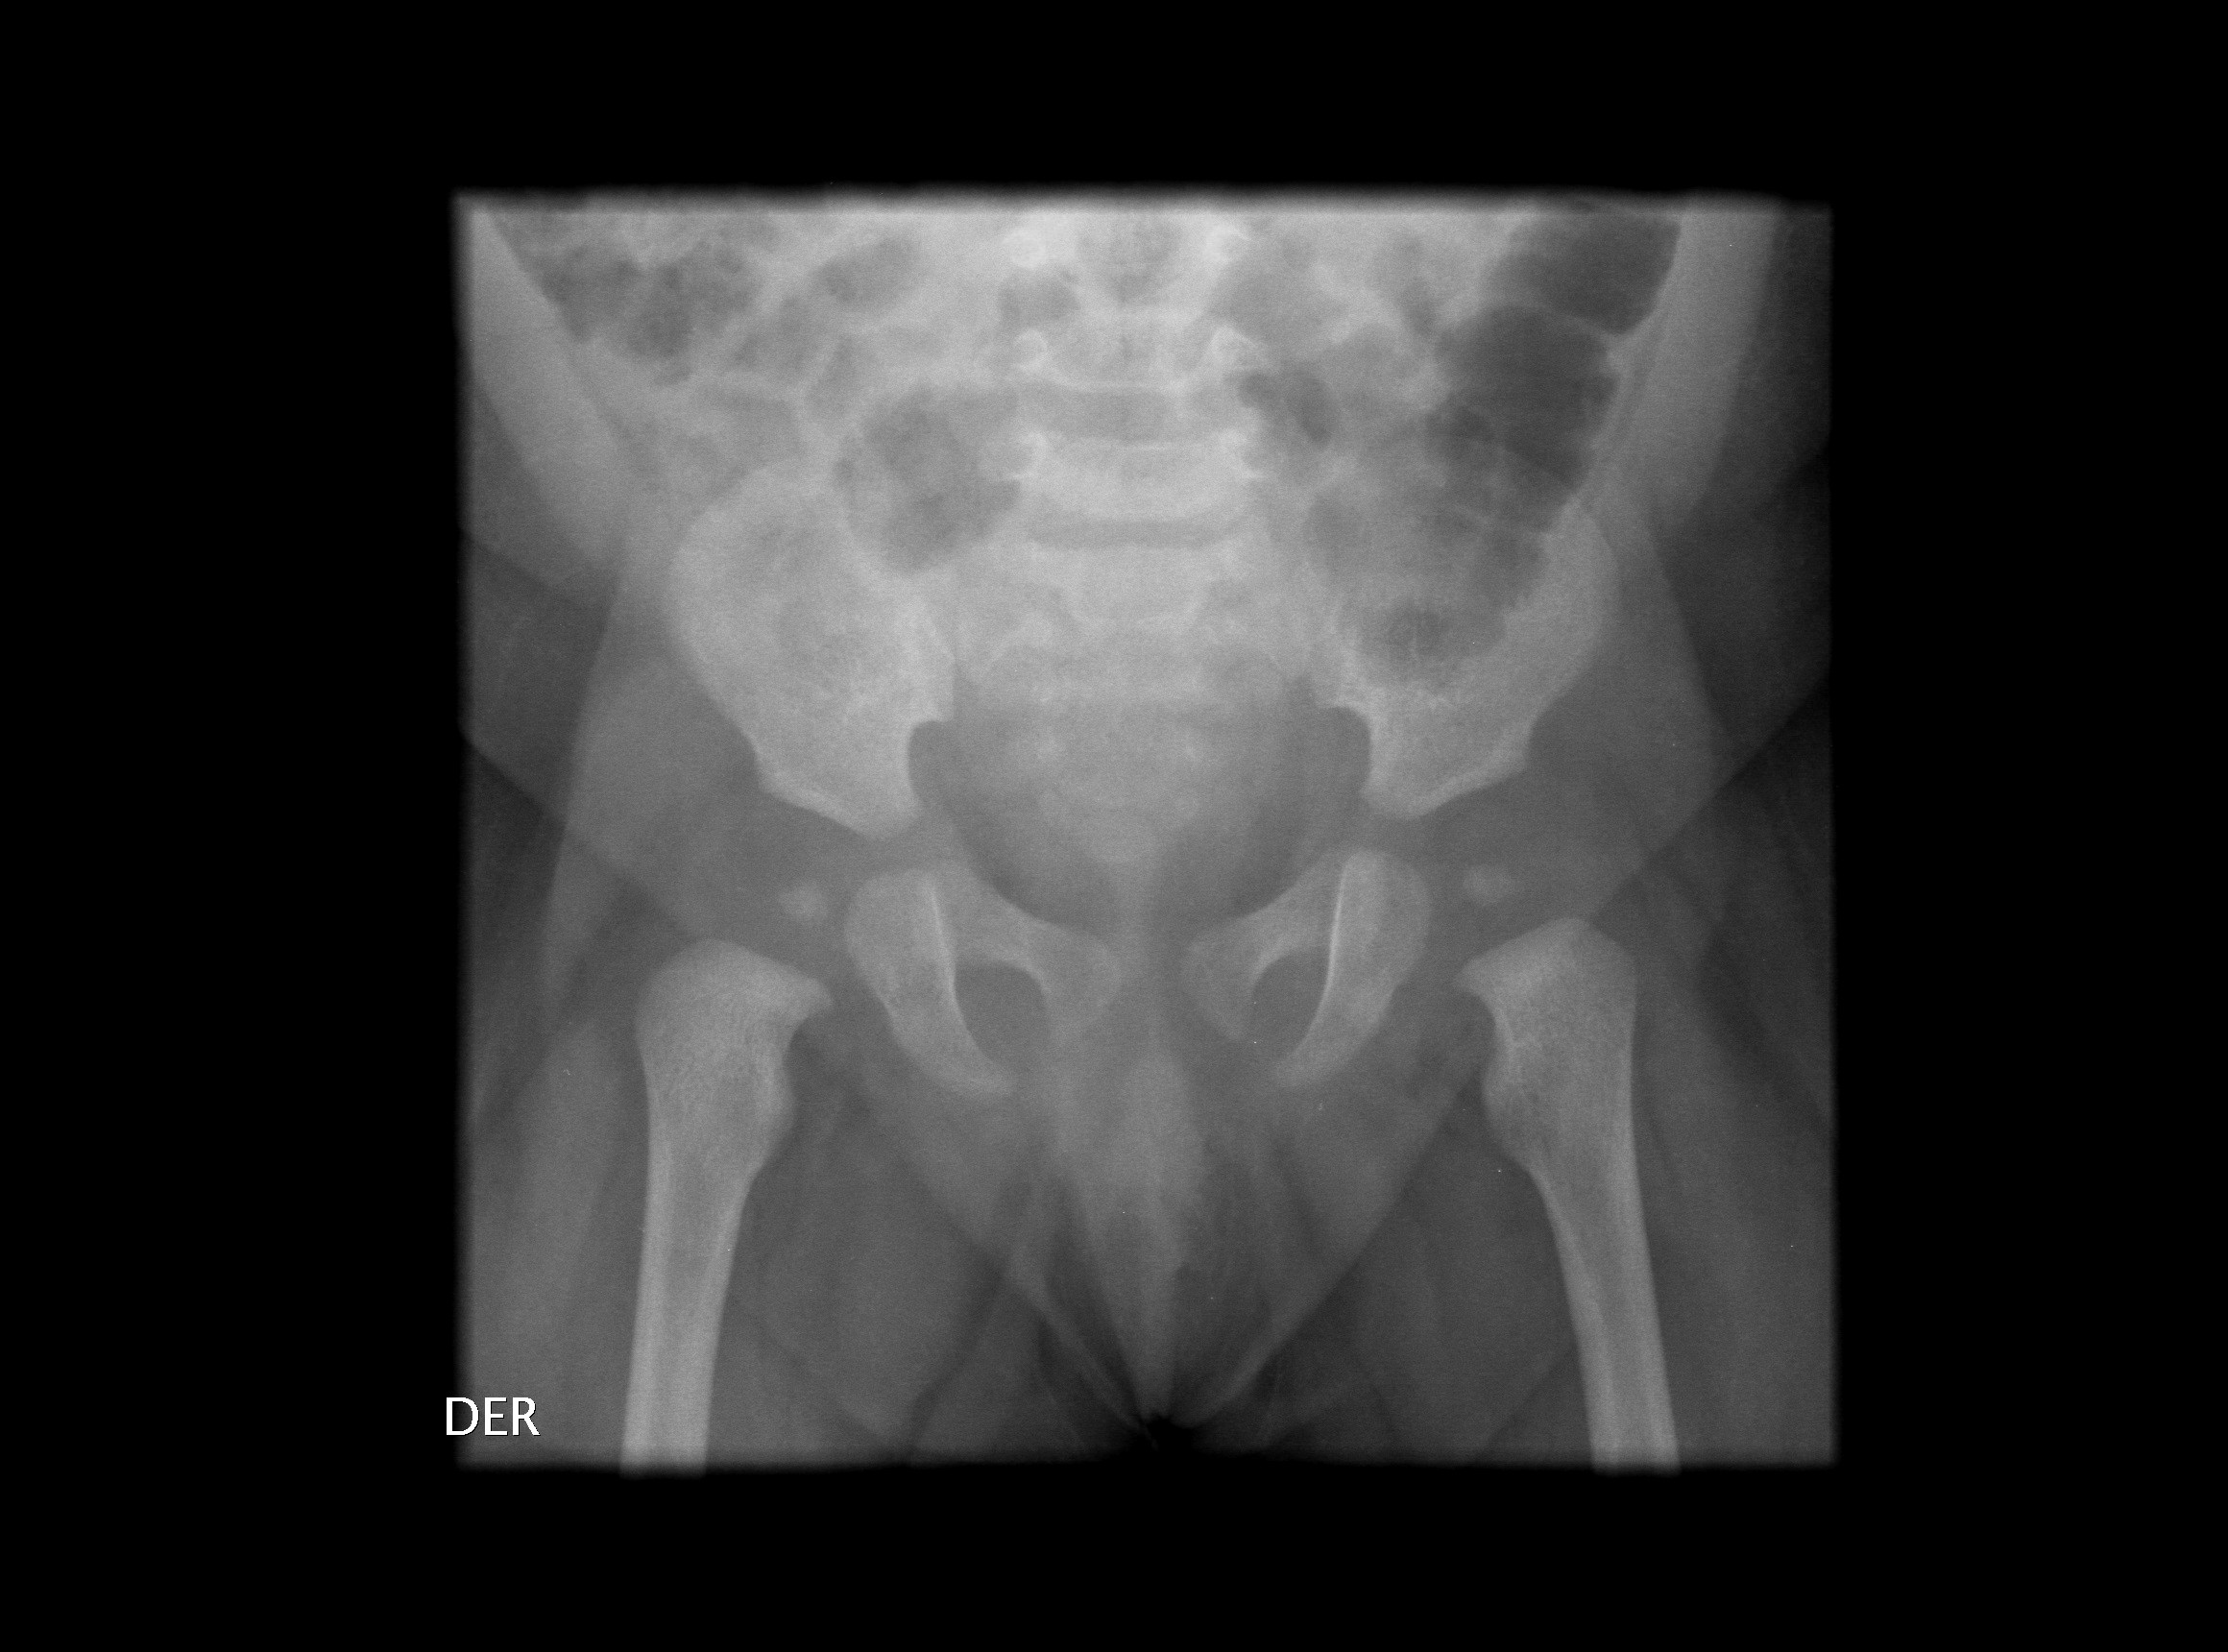

In [45]:
ddh2 = list(data_dir.glob('Normal/*'))
Image.open(str(ddh2[0]))

In [46]:
train_directory= "C:/Users/palma/Downloads/Nueva carpeta (6)/train/"
val_directory="C:/Users/palma/Downloads/Nueva carpeta (6)/val/"
test_directory="C:/Users/palma/Downloads/Nueva carpeta (6)/test/"

In [47]:
data_dir = train_directory
class_names=os.listdir(train_directory)
print(class_names)

['DDH', 'Normal']


In [48]:
IMAGE_SIZE = (224, 224)
# Default batch size
BATCH_SIZE = 32

In [49]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image


In [50]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_directory,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMAGE_SIZE)


Found 485 files belonging to 2 classes.


In [51]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(val_directory,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMAGE_SIZE)


Found 131 files belonging to 2 classes.


In [52]:
test_dataset = tf.keras.utils.image_dataset_from_directory(test_directory,
                                                                 shuffle=True,
                                                                 batch_size=132,
                                                                 image_size=IMAGE_SIZE)


Found 132 files belonging to 2 classes.


In [53]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)


In [54]:
import matplotlib.pyplot as plt

In [55]:
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, preprocess_input


In [56]:
resnet_model = tf.keras.applications.ResNet50V2(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
)

In [57]:
preprocess_input = tf.keras.applications.resnet_v2.preprocess_input
rescale = tf.keras.layers.Rescaling(1./255.0,offset=-1)

In [58]:
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import f1_score
image_batch, label_batch = next(iter(train_dataset))
feature_batch = resnet_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 2048)


In [59]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [60]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [35]:
preprocess_input = tf.keras.applications.resnet_v2.preprocess_input
rescale = tf.keras.layers.Rescaling(1./255.0,offset=-1)
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.3),
    tf.keras.layers.experimental.preprocessing.RandomContrast(0.5, 2.0),
    tf.keras.layers.experimental.preprocessing.RandomWidth(0.1),
])
for layer in resnet_model.layers:
  layer.trainable = False
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = resnet_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.1)(x)
predictions = prediction_layer(x)
model = tf.keras.Model(inputs=inputs, outputs=predictions)
custom_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer=custom_optimizer, metrics=['accuracy'])


In [36]:
from sklearn.utils.class_weight import compute_class_weight

In [37]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=10)

lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',patience=8)

In [38]:
epoch=10

In [39]:
history = model.fit(train_dataset,
                    epochs=epoch,
                    validation_data=validation_dataset)


Epoch 1/10
16/16 [==============================] - 33s 2s/step - loss: 0.3450 - accuracy: 0.8433 - val_loss: 0.3836 - val_accuracy: 0.7557
Epoch 2/10
16/16 [==============================] - 27s 2s/step - loss: 0.3477 - accuracy: 0.8619 - val_loss: 0.3921 - val_accuracy: 0.7557
Epoch 3/10
16/16 [==============================] - 28s 2s/step - loss: 0.3038 - accuracy: 0.8639 - val_loss: 0.3422 - val_accuracy: 0.7786
Epoch 4/10
16/16 [==============================] - 28s 2s/step - loss: 0.3070 - accuracy: 0.8701 - val_loss: 0.3803 - val_accuracy: 0.7557
Epoch 5/10
16/16 [==============================] - 28s 2s/step - loss: 0.2758 - accuracy: 0.9010 - val_loss: 0.3368 - val_accuracy: 0.7939
Epoch 6/10
16/16 [==============================] - 28s 2s/step - loss: 0.2759 - accuracy: 0.9031 - val_loss: 0.3361 - val_accuracy: 0.8168
Epoch 7/10
16/16 [==============================] - 28s 2s/step - loss: 0.2901 - accuracy: 0.8907 - val_loss: 0.3135 - val_accuracy: 0.8397
Epoch 8/10
16/16 [==

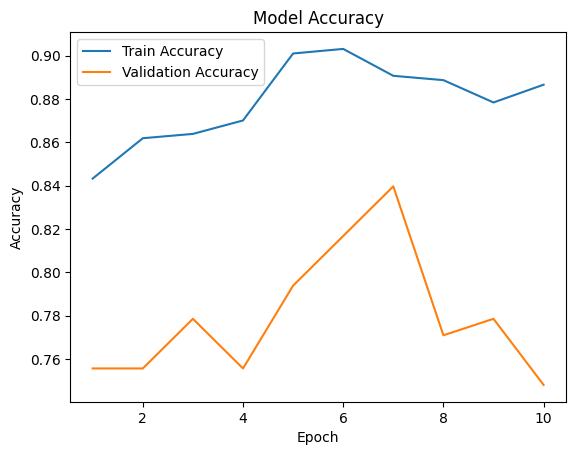

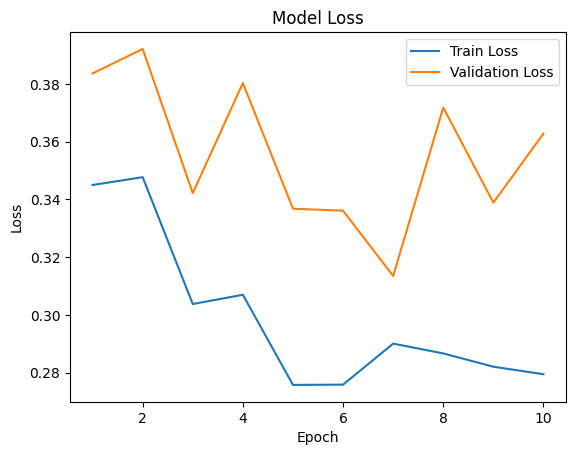

In [1]:
import matplotlib.pyplot as plt

# Valores proporcionados
train_loss = [0.3450, 0.3477, 0.3038, 0.3070, 0.2758, 0.2759, 0.2901, 0.2867, 0.2821, 0.2795]
train_accuracy = [0.8433, 0.8619, 0.8639, 0.8701, 0.9010, 0.9031, 0.8907, 0.8887, 0.8784, 0.8866]

val_loss = [0.3836, 0.3921, 0.3422, 0.3803, 0.3368, 0.3361, 0.3135, 0.3718, 0.3389, 0.3628]
val_accuracy = [0.7557, 0.7557, 0.7786, 0.7557, 0.7939, 0.8168, 0.8397, 0.7710, 0.7786, 0.7481]

# Generar la lista de épocas automáticamente
epochs = list(range(1, len(train_loss) + 1))

# Plot accuracy
plt.plot(epochs, train_accuracy, label='Train Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(epochs, train_loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [40]:
from tensorflow.keras.preprocessing import image
def classify_image(image_path):
    # Convertir la imagen de PIL a un array de NumPy y preprocesar
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    predictions = model.predict(img_array).flatten()
    predictions = tf.nn.sigmoid(predictions)
    predictions = tf.where(predictions < 0.5, 0, 1)
    return predictions

In [41]:
score = model.evaluate(train_dataset)

print("Train Loss: ", score[0])
print("Train Accuracy: ", score[1])

score = model.evaluate(test_dataset)
print("\nTest loss: ", score[0])
print("Test Accuracy: ", score[1])

16/16 [==============================] - 21s 1s/step - loss: 0.2604 - accuracy: 0.8825
Train Loss:  0.2604427933692932
Train Accuracy:  0.8824742436408997
1/1 [==============================] - 5s 5s/step - loss: 0.3222 - accuracy: 0.8030

Test loss:  0.32223665714263916
Test Accuracy:  0.8030303120613098


In [42]:
from sklearn.metrics import confusion_matrix,classification_report

image_batch, label_batch = next(iter(test_dataset))
predictions = model.predict(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)
# Generar la matriz de confusión
conf_matrix = confusion_matrix(label_batch, predictions)

report = classification_report(label_batch, predictions)
print(report)

# Imprimir la matriz de confusión
print("Matriz de Confusión:")
print(conf_matrix)

5/5 [==============================] - 6s 984ms/step
Predictions:
 [0 0 1 0 1 0 1 0 0 1 1 1 1 1 0 1 1 1 0 0 0 1 0 0 1 0 0 1 0 1 0 0 0 1 0 1 0
 0 1 0 1 1 0 0 0 1 1 0 1 0 0 0 0 1 1 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1
 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 0 0 0 0 1 1 0 0 0 0 0 0 1 0 1 0 1 1 1 1
 0 0 1 0 0 0 0 1 1 0 0 0 0 0 1 1 1 0 1 0 0]
Labels:
 tf.Tensor(
[0 0 1 0 1 0 1 0 0 1 1 1 1 1 0 1 1 1 0 0 0 1 0 0 1 1 0 1 0 1 0 0 0 1 0 1 0
 0 1 0 1 1 0 0 0 1 1 0 1 0 0 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 0 1
 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 0 1 1 1 0 0 0 0 0 0 1 0 1 0 1 1 1 1
 0 1 1 0 1 0 0 1 1 1 0 0 0 0 1 1 1 1 1 0 0], shape=(132,), dtype=int32)
              precision    recall  f1-score   support

           0       0.79      1.00      0.88        52
           1       1.00      0.82      0.90        80

    accuracy                           0.89       132
   macro avg       0.89      0.91      0.89       132
weighted avg       0.92      0.89      0.90       132

Matriz de Confusión:

Fine tuning

In [43]:
fine_tune_at = 100
for layer in resnet_model.layers[:fine_tune_at]:
    layer.trainable = True

In [44]:
custom_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001/10)
model.compile(loss='binary_crossentropy', optimizer=custom_optimizer, metrics=['accuracy'])


In [45]:
fine_tune_epochs = 10
total_epochs =  epoch+fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset,
                         batch_size=32)




Epoch 10/20
16/16 [==============================] - 99s 6s/step - loss: 0.8365 - accuracy: 0.9113 - val_loss: 2.3756 - val_accuracy: 0.7786
Epoch 11/20
16/16 [==============================] - 93s 6s/step - loss: 0.7977 - accuracy: 0.9155 - val_loss: 0.9426 - val_accuracy: 0.8855
Epoch 12/20
16/16 [==============================] - 92s 6s/step - loss: 0.9979 - accuracy: 0.8784 - val_loss: 2.3254 - val_accuracy: 0.7634
Epoch 13/20
16/16 [==============================] - 93s 6s/step - loss: 0.7858 - accuracy: 0.9134 - val_loss: 3.4945 - val_accuracy: 0.6565
Epoch 14/20
16/16 [==============================] - 93s 6s/step - loss: 0.6262 - accuracy: 0.9361 - val_loss: 2.2030 - val_accuracy: 0.7786
Epoch 15/20
16/16 [==============================] - 90s 6s/step - loss: 1.0319 - accuracy: 0.8969 - val_loss: 1.0491 - val_accuracy: 0.8855
Epoch 16/20
16/16 [==============================] - 92s 6s/step - loss: 1.2252 - accuracy: 0.8907 - val_loss: 1.7749 - val_accuracy: 0.7863
Epoch 17/20
1

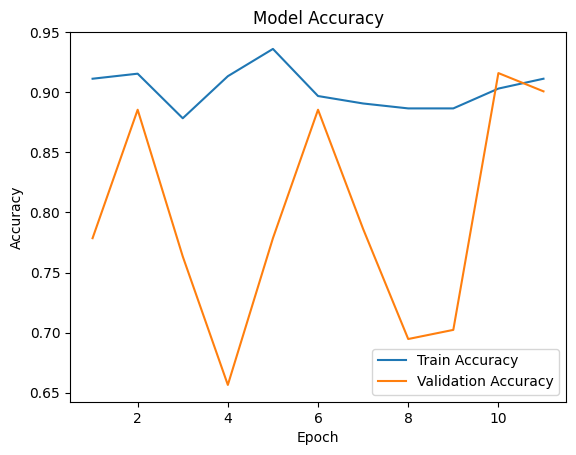

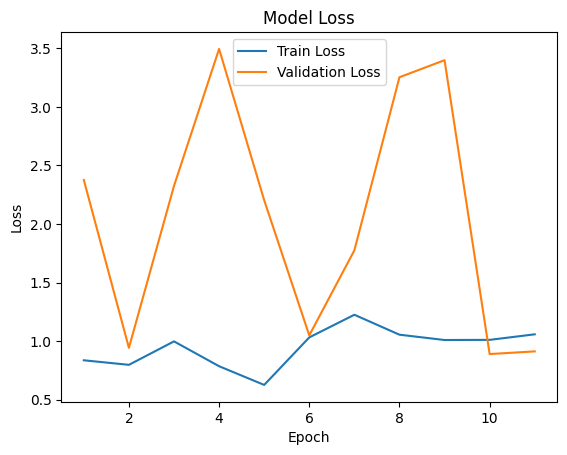

In [2]:
train_loss = [0.8365, 0.7977, 0.9979, 0.7858, 0.6262, 1.0319, 1.2252, 1.0549, 1.0096, 1.0108, 1.0582]
train_accuracy = [0.9113, 0.9155, 0.8784, 0.9134, 0.9361, 0.8969, 0.8907, 0.8866, 0.8866, 0.9031, 0.9113]

val_loss = [2.3756, 0.9426, 2.3254, 3.4945, 2.2030, 1.0491, 1.7749, 3.2528, 3.3983, 0.8897, 0.9125]
val_accuracy = [0.7786, 0.8855, 0.7634, 0.6565, 0.7786, 0.8855, 0.7863, 0.6947, 0.7023, 0.9160, 0.9008]

# Generar la lista de épocas automáticamente
epochs = list(range(1, len(train_loss) + 1))

# Plot accuracy
plt.plot(epochs, train_accuracy, label='Train Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(epochs, train_loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [46]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy:', accuracy)


1/1 [==============================] - 5s 5s/step - loss: 0.6380 - accuracy: 0.9394
Test accuracy: 0.939393937587738


In [47]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)
print('Test loss :', loss)

1/1 [==============================] - 6s 6s/step - loss: 0.6380 - accuracy: 0.9394
Test accuracy : 0.939393937587738
Test loss : 0.637980580329895


In [48]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)
# Generar la matriz de confusión
conf_matrix = confusion_matrix(label_batch, predictions)

report = classification_report(label_batch, predictions)
print(report)

# Imprimir la matriz de confusión
print("Matriz de Confusión:")
print(conf_matrix)

Predictions:
 [1 0 1 1 1 1 0 1 1 1 1 0 0 1 0 0 1 1 1 1 1 0 0 1 1 0 1 1 0 0 0 1 0 1 1 1 1
 1 0 1 1 1 1 0 1 1 1 0 0 0 0 1 0 1 1 1 0 1 0 0 0 0 0 1 0 1 1 1 1 1 1 0 1 1
 0 1 1 1 0 0 0 1 1 0 1 0 1 1 0 0 0 1 0 0 0 1 0 1 1 1 1 1 0 1 1 0 1 1 1 0 1
 1 0 0 0 1 0 0 0 0 0 1 0 1 1 1 1 1 0 0 1 0]
Labels:
 [1 0 1 1 1 1 0 1 1 1 1 1 0 1 0 0 1 1 1 1 1 0 0 1 1 0 1 1 0 0 0 1 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 0 1 1 1 1 1 0 0 0 0 0 1 0 1 1 1 1 1 1 0 0 1
 0 1 1 1 0 0 0 1 1 0 1 0 1 1 0 0 0 1 0 0 0 1 0 1 1 1 1 1 0 1 1 0 1 1 1 0 1
 1 0 1 0 1 0 0 0 0 0 1 0 1 1 1 1 1 0 0 1 0]
              precision    recall  f1-score   support

           0       0.91      0.98      0.94        52
           1       0.99      0.94      0.96        80

    accuracy                           0.95       132
   macro avg       0.95      0.96      0.95       132
weighted avg       0.96      0.95      0.95       132

Matriz de Confusión:
[[51  1]
 [ 5 75]]


In [49]:
from tensorflow.keras.preprocessing import image
def classify_image(image_path):
    # Convertir la imagen de PIL a un array de NumPy y preprocesar
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    predictions = model.predict(img_array).flatten()
    predictions = tf.nn.sigmoid(predictions)
    predictions = tf.where(predictions < 0.5, 0, 1)
    return predictions

In [50]:
import os
image_dir = "C:/Users/palma/Downloads/Nueva carpeta (6)/test/Normal/"
image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]
cont0=0
cont1=0
for images in image_files:
    values=classify_image(image_dir+images)
    if(0 in values):
        cont0=cont0+1
    else:
        cont1=cont1+1

1/1 [==============================] - 0s 94ms/step


In [51]:
import os
image_dir = "C:/Users/palma/Downloads/Nueva carpeta (6)/test/DDH/"
image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]
cont0=0
cont1=0
for images in image_files:
    values=classify_image(image_dir+images)
    if(0 in values):
        cont0=cont0+1
    else:
        cont1=cont1+1

1/1 [==============================] - 0s 92ms/step


In [52]:
print(cont1)
print(cont0)

0
52


In [53]:
import os
image_dir = "C:/Users/palma/Downloads/Normalitos/"
image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]
cont0=0
cont1=0
for images in image_files:
    values=classify_image(image_dir+images)
    if(0 in values):
        cont0=cont0+1
    else:
        cont1=cont1+1

1/1 [==============================] - 0s 87ms/step


In [54]:
print(cont1)
print(cont0)

102
19


In [55]:
import os
image_dir = "C:/Users/palma/Downloads/Nueva carpeta (6)/test/DDH/"
image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]
cont0=0
cont1=0
for images in image_files:
    values=classify_image(image_dir+images)
    if(0 in values):
        cont0=cont0+1
    else:
        cont1=cont1+1

1/1 [==============================] - 0s 92ms/step


In [56]:
print(cont1)
print(cont0)

0
52


In [57]:
image_dir = "C:/Users/palma/Downloads/Nueva carpeta (6)/test/Normal/"
image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]
cont0=0
cont1=0
for images in image_files:
    values=classify_image(image_dir+images)
    if(0 in values):
        cont0=cont0+1
    else:
        cont1=cont1+1

1/1 [==============================] - 0s 93ms/step


In [58]:
print(cont1)
print(cont0)

72
8


In [59]:
model.save("C:/Users/palma/Downloads/Modelo_FInal_Resnet50")


INFO:tensorflow:Assets written to: C:/Users/palma/Downloads/Modelo_FInal_Resnet50\assets


INFO:tensorflow:Assets written to: C:/Users/palma/Downloads/Modelo_FInal_Resnet50\assets
